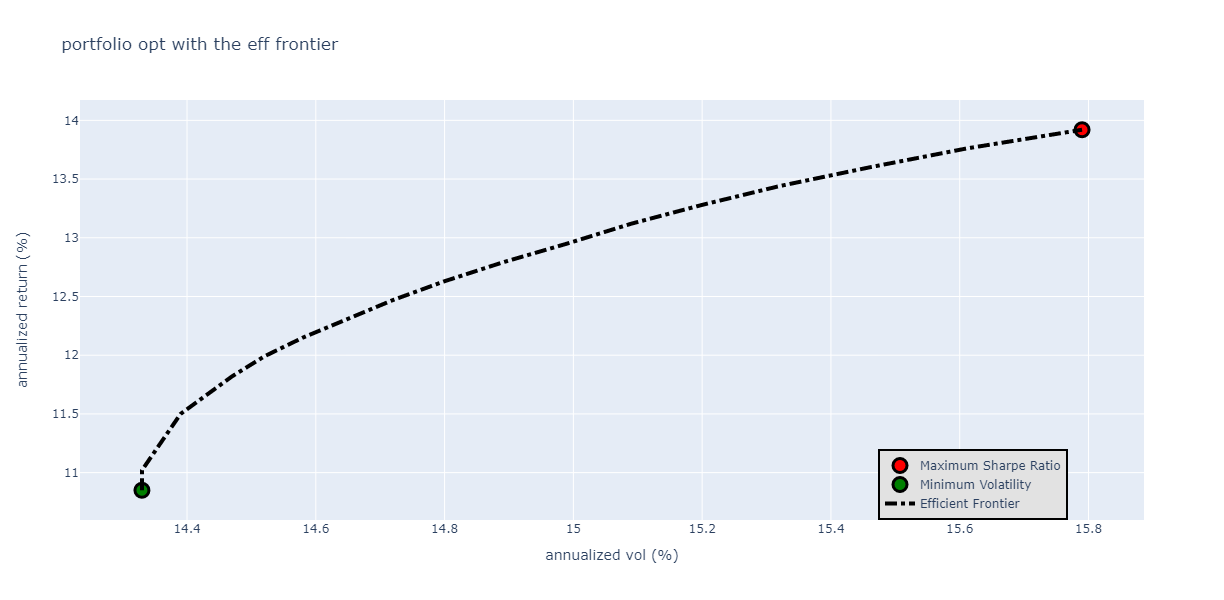

In [12]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
import scipy.optimize as sc
import plotly.graph_objects as go

def getData(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns= stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

def portfolioPerformance(weights, meanReturns, covMatrix):
    returns = np.sum(meanReturns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights)))*np.sqrt(252)
    return returns, std

def negativeSR(weights, meanReturns, covMatrix, riskFreeRate = 0):
    pReturns, pStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return -(pReturns - riskFreeRate)/pStd

def maxSR(meanReturns, covMatrix, riskFreeRate = 0, constraintSet=(0,1)):
    '''Minimize negative SR, altering the weights of the port'''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})  # fun is the objective function which is minimize negativeSR, documentsda var. lambda fonk = weightslerin toplaminin 1 olmasi gerektigini soyler
                                                                  #Equality constraint means that the constraint function result is to be zero whereas inequality means that it is to be non-negative
    bound = constraintSet # 0 la 1 arasi olacak dedik yukarda
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(negativeSR, numAssets*[1./numAssets],args=args, method='SLSQP', bounds=bounds, constraints=constraints)   
    return result      #negativesr yi min etmek istiyosun, ikincisi her asset esit agirlikta olacak diyor liste seklinde. bu negativesr nin ilk argumenti olan weights'i optimize 
                        #edecegini anliyor. https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    
def portfolioVariance(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]   #std return etsin istiyoruz cunku min std portfolio buldurcaz.

def minimizeVariance(meanReturns, covMatrix, constraintSet=(0,1)):
    ''' minimize port variance by altering weights'''
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})  
    bound = constraintSet 
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(portfolioVariance, numAssets*[1./numAssets],args=args, method='SLSQP', bounds=bounds, constraints=constraints)   
    return result 
    
stocklist = ['CBA', 'BHP', 'TLS']
stocks = [stock+'.AX' for stock in stocklist]

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days= 365)

#weights = np.array([0.3, 0.3, 0.4])

meanReturns, covMatrix = getData(stocks, startDate, endDate)
#portfolioPerformance(weights, meanReturns, covMatrix)

# result = maxSR(meanReturns, covMatrix)
# maxSR, maxweights = result['fun'], result['x']
# print(maxSR, maxweights)

# minVarResult = minimizeVariance(meanReturns, covMatrix)
# minVar, minVarweights = minVarResult['fun'], minVarResult['x']
# print(minVar, minVarweights)

def portfolioReturn(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[0]

def efficientOpt(meanReturns, covMatrix, returntarget, constraintSet=(0,1)):
    '''for each returntarget we want to optimize the port for min variance'''
    numAssets = len(meanReturns)
    args=(meanReturns, covMatrix)
    
    constraints = ({'type':'eq', 'fun': lambda x: portfolioReturn(x,meanReturns, covMatrix) - returntarget},
                    {'type': 'eq', 'fun': lambda x: np.sum(x)-1})
    bound = constraintSet
    bounds = tuple((bound for asset in range(numAssets)))
    effOpt = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return effOpt

def calculatedResults(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1)):
    '''  output max SR, min vol portfolio and later efficient frontier'''
    # max sharpe ratio portfolio
    maxSR_Portfolio = maxSR(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = portfolioPerformance(maxSR_Portfolio['x'], meanReturns, covMatrix)
    maxSR_allocation = pd.DataFrame(maxSR_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    maxSR_allocation.allocation = [round(i*100,0) for i in maxSR_allocation.allocation]
    
    # min vol portfolio
    minVol_Portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = portfolioPerformance(minVol_Portfolio['x'], meanReturns, covMatrix)
    minVol_allocation = pd.DataFrame(minVol_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    minVol_allocation.allocation = [round(i*100,0) for i in minVol_allocation.allocation]
    
    #efficient frontier
    efficientList = []
    targetReturns = np.linspace(minVol_returns, maxSR_returns, 20)
    for target in targetReturns:
        efficientList.append(efficientOpt(meanReturns, covMatrix, target)['fun'])
    
    maxSR_returns, maxSR_std = round(maxSR_returns*100,2), round(maxSR_std*100,2)
    minVol_returns, minVol_std = round(minVol_returns*100,2), round(minVol_std*100,2)
    
    return maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns
    
def EF_graph(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1)):   
    maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns = calculatedResults(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1))

    #Max SR
    MaxSharpeRatio = go.Scatter(
        name='Maximum Sharpe Ratio',
        mode='markers',
        x=[maxSR_std],
        y=[maxSR_returns],
        marker=dict(color='red',size=14,line=dict(width=3, color='black')
    ))
    #Min Vol
    MinVol = go.Scatter(
        name='Minimum Volatility',
        mode='markers',
        x=[minVol_std],
        y=[minVol_returns],
        marker=dict(color='green',size=14,line=dict(width=3, color='black')
    ))
    #efficient frontier
    EF_curve = go.Scatter(
        name='Efficient Frontier',
        mode='lines',
        x=[round(ef_std*100,2) for ef_std in efficientList],
        y=[round(target*100,2) for target in targetReturns],
        line=dict(color='black',width=4,dash='dashdot')
    )
    
    data = [MaxSharpeRatio, MinVol, EF_curve]
    
    layout = go.Layout(
        title = 'portfolio opt with the eff frontier',
        yaxis = dict(title='annualized return (%)'),
        xaxis = dict(title='annualized vol (%)'),
        showlegend = True,
        legend = dict(
            x = 0.75, y = 0, traceorder = 'normal',
            bgcolor='#E2E2E2',
            bordercolor='black',
            borderwidth=2),
        width=800,
        height=600)
    
    fig = go.Figure(data=data, layout=layout)
    return fig.show()

EF_graph(meanReturns, covMatrix)
        